<a href="https://colab.research.google.com/github/YogaWithParas/portfolio-analysis-tool/blob/main/Potfolio_Optimizer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/robertmartin8/PyPortfolioOpt
!pip install pypfopt
!pip install yfinance
!pip install ipywidgets
!pip install matplotlib

  Cloning https://github.com/robertmartin8/PyPortfolioOpt to /tmp/pip-req-build-88fv46sd
  Running command git clone --filter=blob:none --quiet https://github.com/robertmartin8/PyPortfolioOpt /tmp/pip-req-build-88fv46sd
  Resolved https://github.com/robertmartin8/PyPortfolioOpt to commit 65cabcee11d91777d63628744c36869ec64a1c85
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyportfolioopt: filename=pyportfolioopt-1.5.6-py3-none-any.whl size=62705 sha256=280c2bd2f2249d62a0b1a0f0d327c233364afc82693a058b73d4aa4f5e0cfa3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cffqrrly/wheels/43/c9/86/eb0dcd3c9756efe4cd1c136aafd9f2e1088057fb2e149fadaa
Successfully built pyportfolioopt
ERROR: Could not find a version that satisfies the requirement pypfopt (from versions: none)
ERROR: No matching distribution found for pypfopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s e

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No valid returns for the period: COVID-19 Crash
No valid returns for the period: Post-COVID Recovery
              Period  CAGR (%)  Volatility (%)  Sharpe Ratio
0  Recent Volatility  1.181268        11.95282      0.098828
The minimum achievable portfolio volatility is 0.082.


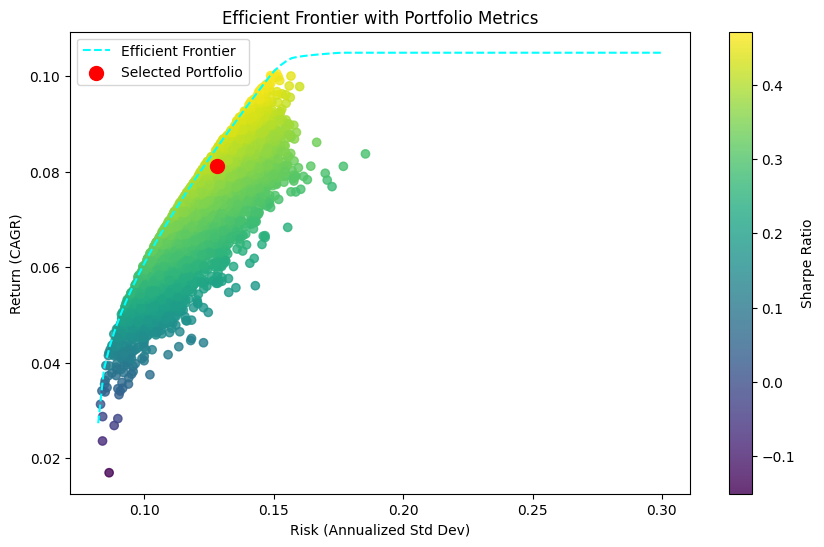

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

# Function to calculate CAGR
def calculate_cagr(data):
    """
    Calculate the Compound Annual Growth Rate (CAGR) for securities.
    """
    if data.empty:
        raise ValueError("Price data is empty. Cannot calculate CAGR.")
    total_periods = len(data) / 252  # Assuming 252 trading days per year
    start_prices = data.iloc[0]
    end_prices = data.iloc[-1]
    cagr = (end_prices / start_prices) ** (1 / total_periods) - 1
    return cagr.fillna(0)

# Function to optimize the portfolio
def optimize_portfolio(mean_returns, covariance, target_risk, solver="SCS"):
    """
    Optimize portfolio for the given target risk.
    """
    try:
        ef = EfficientFrontier(mean_returns, covariance, solver=solver)
        ef.efficient_risk(target_risk)
        weights = ef.clean_weights()
        portfolio_return = np.dot(list(weights.values()), mean_returns)
        portfolio_risk = np.sqrt(np.dot(list(weights.values()), np.dot(covariance, list(weights.values()))))
        sharpe_ratio = (portfolio_return - config["risk_free_rate"]) / portfolio_risk
        return weights, (portfolio_return, portfolio_risk, sharpe_ratio)
    except Exception as e:
        print(f"Optimization failed: {e}")
        return None, None

# Function to fetch data with error handling
def fetch_data_with_error_handling(tickers, start_date, end_date):
    """
    Fetch historical price data for specified tickers, handling errors gracefully.
    """
    valid_tickers = []
    data_frames = []
    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start_date, end=end_date)["Adj Close"]
            if not df.empty:
                valid_tickers.append(ticker)
                data_frames.append(df)
            else:
                print(f"No data found for ticker: {ticker}")
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")

    if data_frames:
        data = pd.concat(data_frames, axis=1, keys=valid_tickers)
        return data
    else:
        raise ValueError("No valid tickers found after filtering.")

# Function to generate random portfolios
def generate_random_portfolios(mean_returns, covariance, risk_free_rate, num_portfolios=10000):
    """
    Generate random portfolios for comparison.
    """
    results = {"Returns": [], "Risk": [], "Sharpe": []}
    for _ in range(num_portfolios):
        random_weights = np.random.random(len(mean_returns))
        random_weights /= np.sum(random_weights)

        portfolio_return = np.dot(random_weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(covariance, random_weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
        results["Returns"].append(portfolio_return)
        results["Risk"].append(portfolio_risk)
        results["Sharpe"].append(sharpe_ratio)
    return pd.DataFrame(results)

# Function to test portfolio performance
def test_portfolio_performance(data, weights, test_periods):
    """
    Test portfolio performance during specified periods.
    """
    results = []
    for period_name, (start_date, end_date) in test_periods.items():
        period_data = data.loc[start_date:end_date]
        if period_data.empty:
            print(f"No data for the period: {period_name}")
            continue

        # Calculate returns with proper handling
        period_returns = period_data.pct_change(fill_method=None).dropna()
        if len(period_returns) == 0:
            print(f"No valid returns for the period: {period_name}")
            continue

        portfolio_returns = period_returns.dot(weights)

        # Calculate metrics
        cagr = (1 + portfolio_returns).prod() ** (1 / max((len(period_returns) / 252), 1e-10)) - 1
        annual_volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = cagr / annual_volatility if annual_volatility > 0 else 0

        results.append({
            "Period": period_name,
            "CAGR (%)": cagr * 100,
            "Volatility (%)": annual_volatility * 100,
            "Sharpe Ratio": sharpe_ratio
        })
    return pd.DataFrame(results)

# Plot efficient frontier and portfolios
def plot_portfolios(mean_returns, covariance, risk_free_rate, random_portfolios, given_weights, target_risk, optimized_performance):
    """
    Plot the efficient frontier with portfolio metrics highlighted.
    """
    ef = EfficientFrontier(mean_returns, covariance)
    ef.min_volatility()
    global_min_volatility = ef.portfolio_performance(risk_free_rate=risk_free_rate)[1]
    print(f"The minimum achievable portfolio volatility is {global_min_volatility:.3f}.")

    # Generate efficient frontier curve
    efficient_risks, efficient_returns = [], []
    for risk in np.linspace(global_min_volatility, 0.3, 100):
        ef_temp = EfficientFrontier(mean_returns, covariance)
        ef_temp.efficient_risk(risk)
        perf = ef_temp.portfolio_performance(risk_free_rate=risk_free_rate)
        efficient_returns.append(perf[0])
        efficient_risks.append(risk)

    # Plot efficient frontier
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        random_portfolios["Risk"], random_portfolios["Returns"], c=random_portfolios["Sharpe"], cmap="viridis", alpha=0.8
    )
    plt.colorbar(scatter, label="Sharpe Ratio")
    plt.plot(efficient_risks, efficient_returns, linestyle="--", color="cyan", label="Efficient Frontier")

    # Highlight Selected Portfolio
    given_return = np.dot(given_weights, mean_returns)
    given_risk = np.sqrt(np.dot(given_weights.T, np.dot(covariance, given_weights)))
    plt.scatter(given_risk, given_return, color="red", label="Selected Portfolio", s=100)

    # Highlight Optimized Portfolio
    #optimized_return, optimized_risk = optimized_performance[0], optimized_performance[1]
    #plt.scatter(optimized_risk, optimized_return, color="blue", label="Optimized Portfolio", s=100)

    plt.title("Efficient Frontier with Portfolio Metrics")
    plt.xlabel("Risk (Annualized Std Dev)")
    plt.ylabel("Return (CAGR)")
    plt.legend()
    plt.show()

# Define test periods
test_periods = {
    "COVID-19 Crash": ("2020-02-01", "2020-03-31"),
    "Post-COVID Recovery": ("2020-04-01", "2021-12-31"),
    "Recent Volatility": ("2022-01-01", "2023-12-31")
}

if __name__ == "__main__":
    # Configuration
    config = {
        "tickers": ["JNJ", "PG", "KO", "TD", "BAM"],
        "weights": [0.10, 0.10, 0.05, 0.10, 0.05],
        "start_date": "2013-01-01",
        "end_date": "2023-12-31",
        "risk_free_rate": 0.03
    }

    # Fetch data
    data = fetch_data_with_error_handling(config["tickers"], config["start_date"], config["end_date"])
    config["mean_returns"] = calculate_cagr(data)
    config["covariance"] = CovarianceShrinkage(data).ledoit_wolf()

    # Normalize weights
    normalized_weights = np.array(config["weights"]) / np.sum(config["weights"])

    # Optimize portfolio
    optimized_weights, optimized_performance = optimize_portfolio(
        config["mean_returns"], config["covariance"], target_risk=0.18
    )

    # Generate random portfolios
    random_portfolios = generate_random_portfolios(config["mean_returns"], config["covariance"], config["risk_free_rate"])

    # Test portfolio performance
    test_results = test_portfolio_performance(data, normalized_weights, test_periods)
    print(test_results)

    # Plot performance metrics
    plot_portfolios(config["mean_returns"], config["covariance"], config["risk_free_rate"], random_portfolios, normalized_weights, 0.18, optimized_performance)
